<a href="https://colab.research.google.com/github/adenurchalisa/Automatic-Photo-Clustering-System-Optimization-HDBSCAN/blob/main/notebooks/11_Noise_Composition_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 11: Analisis Komposisi Noise

## Mengapa Notebook Ini Penting?

Sebelum masuk ke CGA (Cluster Generation/Augmentation) di Eksperimen 2, kita perlu memahami **mengapa** suatu poin menjadi noise. Ada dua kemungkinan yang memiliki implikasi sangat berbeda:

### Tipe 1: Genuine Singleton (Few-Shot Person)
Orang yang hanya muncul satu atau beberapa kali dalam seluruh dataset. Embedding mereka valid, namun jumlahnya terlalu sedikit untuk membentuk cluster dengan `min_cluster_size` yang ditentukan. **Ini adalah justifikasi utama CGA** — synthetic augmentation dapat "memperbanyak" embedding orang ini agar mencapai threshold minimum cluster.

### Tipe 2: Outlier Kualitas Rendah (Low-Quality Detection)
Embedding dari foto yang blur, pose ekstrem, oklusu wajah berat, atau pencahayaan buruk. HDBSCAN membuang ini karena berada di region berdensitas sangat rendah di embedding space — bukan karena orang tersebut langka, tapi karena embedding-nya tidak representatif.

**Jika mayoritas noise adalah Tipe 2, CGA tidak akan efektif** — menambah synthetic embedding dari sumber yang sudah berkualitas buruk hanya akan memperburuk cluster. Sebaliknya, jika mayoritas adalah Tipe 1, CGA memiliki justifikasi yang kuat.

## Metodologi Analisis

1. **Frekuensi per identitas dalam noise** — apakah noise terdistribusi ke banyak orang (singleton) atau terkonsentrasi?
2. **Per-image noise distribution** — apakah satu foto memiliki banyak noise? Ini indikasi kualitas foto buruk.
3. **Embedding quality proxy** — menghitung L2-norm dan jarak ke nearest clustered neighbor sebagai proxy kualitas
4. **Iterative re-clustering noise** — pisahkan noise points lalu cluster ulang dengan `min_cluster_size` yang lebih kecil

---

## Cell 1 — Instalasi & Imports

In [1]:
!pip install hdbscan -q

import numpy as np
import pickle
import time
import os
import warnings
from collections import Counter
from datetime import datetime

import hdbscan
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

print("✅ Libraries loaded")

✅ Libraries loaded


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


## Cell 2 — Konfigurasi

Notebook ini memuat hasil dari Eksperimen 1.5 (Correlation best config) yang menjadi baseline utama analisis noise. Jika hasil dari Notebook 9 atau 10 lebih baik, labels dari sana bisa disubstitusi.

In [2]:
class Config:
    EMBEDDINGS_PATH = '/content/drive/MyDrive/OTW S.KOM/Embeddings/embeddings_data.pkl'
    RESULTS_DIR     = '/content/drive/MyDrive/OTW S.KOM/Results/'
    PLOTS_DIR       = '/content/drive/MyDrive/OTW S.KOM/Results/Plots/'

    BASELINE_PARAMS = {
        'metric'           : 'correlation',
        'min_cluster_size' : 15,
        'min_samples'      : 70,
        'method'           : 'eom',
    }

    REFIT_BASELINE = True

    RECLUSTERING_MCS_LIST = [2, 3, 4, 5, 7, 10]
    RECLUSTERING_MS_LIST  = [1, 2, 3, 5]

    SINGLETON_THRESHOLD = 3


print("="*60)
print("✅ CONFIG LOADED")
print("="*60)
print(f"\n  Baseline: Correlation, mcs={Config.BASELINE_PARAMS['min_cluster_size']}, "
      f"ms={Config.BASELINE_PARAMS['min_samples']}")
print(f"  Singleton threshold: ≤ {Config.SINGLETON_THRESHOLD} kemunculan")
print(f"  Re-clustering MCS grid: {Config.RECLUSTERING_MCS_LIST}")
print(f"  Re-clustering MS grid : {Config.RECLUSTERING_MS_LIST}")

✅ CONFIG LOADED

  Baseline: Correlation, mcs=15, ms=70
  Singleton threshold: ≤ 3 kemunculan
  Re-clustering MCS grid: [2, 3, 4, 5, 7, 10]
  Re-clustering MS grid : [1, 2, 3, 5]


## Cell 3 — Load Data & Reproduce Baseline

Baseline labels (Correlation, mcs=15, ms=70) direproduksi ulang menggunakan `metric='correlation'` pada raw embeddings. Ini diperlukan karena label aktual perlu tersedia di memori untuk analisis noise.

In [4]:
from google.colab import drive

print("="*60)
print("📁 LOAD DATA")
print("="*60)

if not os.path.exists('/content/drive/MyDrive'):
    drive.mount('/content/drive')
else:
    print("✅ Google Drive sudah ter-mount")

os.makedirs(Config.RESULTS_DIR, exist_ok=True)
os.makedirs(Config.PLOTS_DIR, exist_ok=True)

with open(Config.EMBEDDINGS_PATH, 'rb') as f:
    data = pickle.load(f)

embeddings = np.array(data['embeddings']).astype('float32')
metadata   = data['metadata']

print(f"\n✅ Data loaded")
print(f"   Embeddings : {embeddings.shape}")
print(f"   Metadata   : {len(metadata)} entries")

meta_keys = list(metadata[0].keys()) if metadata else []
print(f"   Meta keys  : {meta_keys}")

print(f"\n⏳ Reproducing baseline clustering (Correlation, mcs=15, ms=70)...")
t_start = time.time()

clusterer_baseline = hdbscan.HDBSCAN(
    min_cluster_size         = Config.BASELINE_PARAMS['min_cluster_size'],
    min_samples              = Config.BASELINE_PARAMS['min_samples'],
    cluster_selection_method = Config.BASELINE_PARAMS['method'],
    metric                   = Config.BASELINE_PARAMS['metric'],
)
labels_baseline = clusterer_baseline.fit_predict(embeddings)
elapsed = time.time() - t_start

n_clusters_base = len(set(labels_baseline)) - 1
n_noise_base    = int((labels_baseline == -1).sum())
coverage_base   = float((labels_baseline != -1).sum() / len(labels_baseline))

print(f"   ✅ Selesai ({elapsed:.2f}s)")
print(f"   Clusters     : {n_clusters_base}")
print(f"   Noise        : {n_noise_base:,} ({1-coverage_base:.1%})")
print(f"   Coverage Rate: {coverage_base:.1%}")

📁 LOAD DATA
Mounted at /content/drive

✅ Data loaded
   Embeddings : (12715, 512)
   Metadata   : 12715 entries
   Meta keys  : ['image_path', 'image_filename', 'face_index', 'total_faces_in_image', 'bbox', 'det_score']

⏳ Reproducing baseline clustering (Correlation, mcs=15, ms=70)...
   ✅ Selesai (50.71s)
   Clusters     : 54
   Noise        : 5,564 (43.8%)
   Coverage Rate: 56.2%


## Cell 4 — Analisis Distribusi Noise per Gambar

Pertanyaan: apakah noise points terkonsentrasi di gambar-gambar tertentu?

Jika ya → kemungkinan besar disebabkan oleh **kualitas foto buruk** (blur, pencahayaan, dll.), bukan oleh few-shot person.

Jika tersebar merata → kemungkinan besar adalah **genuine singletons** dari banyak individu berbeda.

Key metadata yang dianalisis:
- `image_filename` atau `image_path` — untuk mengidentifikasi gambar sumber
- `face_id` atau `det_score` — detection confidence score dari InsightFace (jika tersedia)

In [5]:
noise_mask    = labels_baseline == -1
noise_indices = np.where(noise_mask)[0]
noise_meta    = [metadata[i] for i in noise_indices]

print("="*70)
print("📊 ANALISIS 1: DISTRIBUSI NOISE PER GAMBAR")
print("="*70)

img_key = None
for candidate in ['image_filename', 'image_path', 'img_path', 'filename', 'path']:
    if noise_meta and candidate in noise_meta[0]:
        img_key = candidate
        break

if img_key:
    noise_per_img    = Counter([m[img_key] for m in noise_meta])
    all_per_img      = Counter([metadata[i][img_key] for i in range(len(metadata))])
    noise_ratio_img  = {img: noise_per_img.get(img, 0) / total
                        for img, total in all_per_img.items()}

    df_img = pd.DataFrame([
        {'image': k, 'total_faces': all_per_img[k], 'noise_faces': noise_per_img.get(k, 0),
         'noise_ratio': noise_ratio_img[k]}
        for k in all_per_img
    ]).sort_values('noise_ratio', ascending=False)

    print(f"\n  Key metadata gambar: '{img_key}'")
    print(f"  Total gambar unik: {len(all_per_img):,}")
    print(f"  Gambar dengan noise_ratio = 100%: {(df_img['noise_ratio'] == 1.0).sum():,}")
    print(f"  Gambar dengan noise_ratio = 0%  : {(df_img['noise_ratio'] == 0.0).sum():,}")
    print(f"  Rata-rata noise per gambar: {df_img['noise_ratio'].mean():.1%}")
    print(f"\n  Top 10 gambar dengan noise ratio tertinggi:")
    print(df_img.head(10).to_string(index=False))

    high_noise_imgs = df_img[df_img['noise_ratio'] > 0.8]
    print(f"\n  Gambar dengan >80% wajah menjadi noise: {len(high_noise_imgs):,} gambar")
    print(f"  Ini berisi {high_noise_imgs['noise_faces'].sum():,} noise points "
          f"({high_noise_imgs['noise_faces'].sum() / n_noise_base:.1%} dari total noise)")

else:
    print("  ⚠️ Metadata key untuk gambar tidak ditemukan.")
    print(f"  Keys yang tersedia: {list(noise_meta[0].keys()) if noise_meta else 'kosong'}")
    print("  Analisis ini dilewati. Lanjut ke analisis embedding quality.")
    df_img = None

📊 ANALISIS 1: DISTRIBUSI NOISE PER GAMBAR

  Key metadata gambar: 'image_filename'
  Total gambar unik: 2,365
  Gambar dengan noise_ratio = 100%: 557
  Gambar dengan noise_ratio = 0%  : 545
  Rata-rata noise per gambar: 49.0%

  Top 10 gambar dengan noise ratio tertinggi:
       image  total_faces  noise_faces  noise_ratio
POV_1245.JPG            3            3          1.0
POV_1256.JPG            3            3          1.0
POV_1149.JPG            1            1          1.0
POV_9951.JPG            2            2          1.0
POV_9898.JPG            3            3          1.0
POV_9899.JPG            1            1          1.0
POV_9988.JPG            2            2          1.0
POV_9985.JPG            2            2          1.0
POV_1423.JPG            1            1          1.0
POV_1348.JPG            1            1          1.0

  Gambar dengan >80% wajah menjadi noise: 607 gambar
  Ini berisi 1,498 noise points (26.9% dari total noise)


## Cell 5 — Analisis Kualitas Embedding Noise

Dua proxy kualitas yang digunakan:

1. **L2-norm embedding** — InsightFace menghasilkan embedding dengan L2-norm yang bervariasi. Embedding dari foto berkualitas rendah (blur, oklusu) cenderung memiliki L2-norm yang ekstrem (sangat kecil atau sangat besar) dibanding embedding berkualitas baik.

2. **Jarak ke nearest clustered neighbor (DNCN)** — seberapa jauh noise point dari cluster terdekat. Noise dengan DNCN sangat besar kemungkinan adalah outlier sejati. Noise dengan DNCN kecil berarti dia hampir masuk cluster, bisa jadi genuine singleton yang gagal karena threshold `min_cluster_size`.

3. **Detection score** — InsightFace menyimpan confidence score deteksi wajah (`det_score`). Wajah dengan `det_score` rendah lebih mungkin menjadi noise karena embedding-nya tidak representatif.

In [6]:
print("="*70)
print("📊 ANALISIS 2: KUALITAS EMBEDDING NOISE")
print("="*70)

noise_emb      = embeddings[noise_mask]
clustered_emb  = embeddings[~noise_mask]

noise_norms    = np.linalg.norm(noise_emb, axis=1)
cluster_norms  = np.linalg.norm(clustered_emb, axis=1)

print(f"\n  L2-Norm Comparison:")
print(f"  {'Metric':<20} {'Noise':>12} {'Clustered':>12} {'Diff':>10}")
print(f"  {'─'*20} {'─'*12} {'─'*12} {'─'*10}")
for metric_name, fn in [('Mean', np.mean), ('Std', np.std), ('Min', np.min), ('Max', np.max)]:
    n_val = fn(noise_norms)
    c_val = fn(cluster_norms)
    print(f"  {metric_name:<20} {n_val:>12.4f} {c_val:>12.4f} {n_val-c_val:>+10.4f}")

print(f"\n⏳ Menghitung jarak ke nearest clustered neighbor...")
print(f"   (menggunakan 1-NN di ruang embedding asli, Euclidean)")

sample_size = min(3000, len(noise_emb))
noise_sample_idx = np.random.choice(len(noise_emb), sample_size, replace=False)
noise_sample     = noise_emb[noise_sample_idx]

nn = NearestNeighbors(n_neighbors=1, metric='euclidean', n_jobs=-1)
nn.fit(clustered_emb)
dists, _ = nn.kneighbors(noise_sample)
dncn     = dists.flatten()

print(f"   ✅ Selesai (sample: {sample_size:,} noise points)")
print(f"\n  Jarak ke nearest clustered neighbor (DNCN):")
print(f"  Mean   : {dncn.mean():.4f}")
print(f"  Median : {np.median(dncn):.4f}")
print(f"  Std    : {dncn.std():.4f}")
print(f"  Min    : {dncn.min():.4f}")
print(f"  Max    : {dncn.max():.4f}")

pct_close_noise = (dncn < np.percentile(dncn, 25)).mean()
print(f"\n  Noise points di bawah Q25 DNCN (hampir masuk cluster): {pct_close_noise:.1%}")
print(f"  Ini adalah kandidat kuat untuk CGA (mereka genuine singletons, bukan outlier kualitas buruk)")

det_key = None
for candidate in ['det_score', 'detection_score', 'score', 'confidence']:
    if noise_meta and candidate in noise_meta[0]:
        det_key = candidate
        break

if det_key:
    noise_det_scores = np.array([m[det_key] for m in noise_meta])
    cluster_det_scores = np.array([metadata[i][det_key] for i in range(len(metadata)) if not noise_mask[i]])
    print(f"\n  Detection Score ('{det_key}'):")
    print(f"  Noise mean    : {noise_det_scores.mean():.4f}")
    print(f"  Clustered mean: {cluster_det_scores.mean():.4f}")
    print(f"  Noise < 0.5   : {(noise_det_scores < 0.5).mean():.1%} (indikasi kualitas rendah)")
else:
    print(f"\n  ℹ️ Detection score tidak ditemukan di metadata.")
    print(f"  Keys tersedia: {list(noise_meta[0].keys()) if noise_meta else 'kosong'}")
    det_key = None

📊 ANALISIS 2: KUALITAS EMBEDDING NOISE

  L2-Norm Comparison:
  Metric                      Noise    Clustered       Diff
  ──────────────────── ──────────── ──────────── ──────────
  Mean                      20.3339      22.1135    -1.7796
  Std                        3.2404       3.8924    -0.6520
  Min                        7.3907       6.2935    +1.0972
  Max                       29.4997      30.1433    -0.6436

⏳ Menghitung jarak ke nearest clustered neighbor...
   (menggunakan 1-NN di ruang embedding asli, Euclidean)
   ✅ Selesai (sample: 3,000 noise points)

  Jarak ke nearest clustered neighbor (DNCN):
  Mean   : 19.3720
  Median : 19.3724
  Std    : 3.7065
  Min    : 7.2969
  Max    : 27.8419

  Noise points di bawah Q25 DNCN (hampir masuk cluster): 25.0%
  Ini adalah kandidat kuat untuk CGA (mereka genuine singletons, bukan outlier kualitas buruk)

  Detection Score ('det_score'):
  Noise mean    : 0.7493
  Clustered mean: 0.8063
  Noise < 0.5   : 0.0% (indikasi kualitas r

## Cell 6 — Klasifikasi Noise: Singleton vs Low-Quality

Mengklasifikasikan noise points berdasarkan proximity ke cluster yang sudah ada:

- **Probable Singleton (CGA Candidate)**: DNCN < Q25 — dekat dengan cluster yang ada, kemungkinan besar adalah orang yang sama dengan anggota cluster tersebut tapi jumlahnya tidak cukup untuk membentuk cluster baru
- **Borderline**: DNCN Q25–Q75 — tidak dapat ditentukan dengan jelas  
- **Probable Outlier**: DNCN > Q75 — jauh dari semua cluster yang ada, kemungkinan kualitas embedding buruk

Klasifikasi ini langsung menjawab pertanyaan: **seberapa banyak noise yang bisa dibantu oleh CGA?**

In [7]:
print("="*70)
print("📊 ANALISIS 3: KLASIFIKASI NOISE")
print("="*70)

nn_full = NearestNeighbors(n_neighbors=1, metric='euclidean', n_jobs=-1)
nn_full.fit(clustered_emb)

batch_size = 1000
all_dncn   = []

print(f"\n⏳ Menghitung DNCN untuk semua {n_noise_base:,} noise points...")
for start in range(0, len(noise_emb), batch_size):
    end  = min(start + batch_size, len(noise_emb))
    d, _ = nn_full.kneighbors(noise_emb[start:end])
    all_dncn.extend(d.flatten().tolist())

dncn_all = np.array(all_dncn)
print(f"   ✅ Selesai")

q25 = np.percentile(dncn_all, 25)
q75 = np.percentile(dncn_all, 75)

singleton_mask   = dncn_all < q25
borderline_mask  = (dncn_all >= q25) & (dncn_all <= q75)
outlier_mask     = dncn_all > q75

n_singleton  = singleton_mask.sum()
n_borderline = borderline_mask.sum()
n_outlier    = outlier_mask.sum()

print(f"""
┌───────────────────────────────────────────────────────────────────────┐
│                    KLASIFIKASI NOISE POINTS                           │
│                    (berdasarkan DNCN quartile)                        │
├──────────────────────────┬──────────────┬───────────────────────────────┤
│ Kategori                 │    Jumlah    │ Deskripsi                     │
├──────────────────────────┼──────────────┼───────────────────────────────┤
│ Probable Singleton       │ {n_singleton:>8,}   │ DNCN < Q25={q25:.2f}           │
│ (CGA Candidate)          │ ({n_singleton/n_noise_base:.1%})      │ Dekat cluster, bisa di-augment│
├──────────────────────────┼──────────────┼───────────────────────────────┤
│ Borderline               │ {n_borderline:>8,}   │ Q25–Q75                       │
│                          │ ({n_borderline/n_noise_base:.1%})      │ Tidak bisa ditentukan         │
├──────────────────────────┼──────────────┼───────────────────────────────┤
│ Probable Outlier         │ {n_outlier:>8,}   │ DNCN > Q75={q75:.2f}           │
│ (Low Quality)            │ ({n_outlier/n_noise_base:.1%})      │ Jauh dari semua cluster       │
└──────────────────────────┴──────────────┴───────────────────────────────┘
""")

cga_candidates = n_singleton + n_borderline // 2
print(f"  Estimasi CGA candidates (Singleton + sebagian Borderline): ~{cga_candidates:,}")
print(f"  Dari {n_noise_base:,} noise points, ~{cga_candidates/n_noise_base:.1%} berpotensi dibantu oleh CGA")

📊 ANALISIS 3: KLASIFIKASI NOISE

⏳ Menghitung DNCN untuk semua 5,564 noise points...
   ✅ Selesai

┌───────────────────────────────────────────────────────────────────────┐
│                    KLASIFIKASI NOISE POINTS                           │
│                    (berdasarkan DNCN quartile)                        │
├──────────────────────────┬──────────────┬───────────────────────────────┤
│ Kategori                 │    Jumlah    │ Deskripsi                     │
├──────────────────────────┼──────────────┼───────────────────────────────┤
│ Probable Singleton       │    1,391   │ DNCN < Q25=16.98           │
│ (CGA Candidate)          │ (25.0%)      │ Dekat cluster, bisa di-augment│
├──────────────────────────┼──────────────┼───────────────────────────────┤
│ Borderline               │    2,782   │ Q25–Q75                       │
│                          │ (50.0%)      │ Tidak bisa ditentukan         │
├──────────────────────────┼──────────────┼───────────────────────────────┤
│ 

## Cell 7 — Iterative Re-Clustering Noise

Strategi ini memisahkan noise points dan menjalankan HDBSCAN ulang **hanya pada noise** dengan `min_cluster_size` yang jauh lebih kecil.

Logika: noise yang HDBSCAN buang bukan karena embedding-nya tidak baik, melainkan karena threshold minimum cluster terlalu tinggi. Dengan threshold yang lebih rendah, beberapa grup kecil bisa terbentuk.

**Hasil re-clustering** kemudian digabung dengan clustering original untuk mendapatkan label final yang memiliki coverage lebih tinggi tanpa mengubah kualitas cluster yang sudah ada.

In [8]:
print("="*70)
print("🔬 EKSPERIMEN: ITERATIVE RE-CLUSTERING NOISE")
print("="*70)
print(f"\n  Input: {n_noise_base:,} noise points dari baseline")
print(f"  Dimensi: {noise_emb.shape}")

refit_results = []

n_clusters_original = len(set(labels_baseline)) - 1
label_offset        = n_clusters_original

print(f"\n  Label offset: +{label_offset} (agar tidak bentrok dengan label asli)")
print(f"\n  {'mcs':>4} {'ms':>4} | {'new_clusters':>12} {'recovered':>10} {'coverage_gain':>14}")
print(f"  {'─'*4} {'─'*4} | {'─'*12} {'─'*10} {'─'*14}")

for mcs in Config.RECLUSTERING_MCS_LIST:
    for ms in Config.RECLUSTERING_MS_LIST:
        if ms > mcs:
            continue

        re_clusterer = hdbscan.HDBSCAN(
            min_cluster_size         = mcs,
            min_samples              = ms,
            cluster_selection_method = 'eom',
            metric                   = 'correlation',
        )
        re_labels = re_clusterer.fit_predict(noise_emb)

        n_new_clusters = len(set(re_labels)) - (1 if -1 in re_labels else 0)
        n_recovered    = int((re_labels != -1).sum())
        coverage_gain  = n_recovered / len(embeddings)

        re_labels_offset = np.where(re_labels == -1, -1, re_labels + label_offset)

        labels_combined = labels_baseline.copy()
        labels_combined[noise_mask] = re_labels_offset

        mask_combined  = labels_combined != -1
        coverage_total = float(mask_combined.sum() / len(labels_combined))

        sil = None
        if mask_combined.sum() > 10 and len(set(labels_combined[mask_combined])) >= 2:
            sil = float(silhouette_score(
                embeddings[mask_combined], labels_combined[mask_combined],
                metric='correlation', sample_size=3000, random_state=42
            ))

        refit_results.append({
            'mcs'            : mcs,
            'ms'             : ms,
            'n_new_clusters' : n_new_clusters,
            'n_recovered'    : n_recovered,
            'coverage_gain'  : coverage_gain,
            'coverage_total' : coverage_total,
            'silhouette'     : sil,
            'labels_combined': labels_combined.copy(),
        })

        sil_str = f"{sil:.4f}" if sil else "  N/A"
        print(f"  {mcs:>4} {ms:>4} | {n_new_clusters:>12} {n_recovered:>10,} "
              f"{coverage_gain:>14.1%}  (total cov: {coverage_total:.1%}, sil: {sil_str})")

df_refit = pd.DataFrame([{k: v for k, v in r.items() if k != 'labels_combined'}
                          for r in refit_results])
df_valid_refit = df_refit.dropna(subset=['silhouette'])

best_refit = df_valid_refit.loc[df_valid_refit['coverage_total'].idxmax()]
print(f"\n  🏆 Best re-clustering: mcs={int(best_refit['mcs'])}, ms={int(best_refit['ms'])}")
print(f"     New clusters: {int(best_refit['n_new_clusters'])}")
print(f"     Recovered   : {int(best_refit['n_recovered']):,} noise points")
print(f"     Coverage gain: +{best_refit['coverage_gain']:.1%}")
print(f"     Total coverage: {best_refit['coverage_total']:.1%}")
print(f"     Silhouette (combined): {best_refit['silhouette']:.4f}")

🔬 EKSPERIMEN: ITERATIVE RE-CLUSTERING NOISE

  Input: 5,564 noise points dari baseline
  Dimensi: (5564, 512)

  Label offset: +54 (agar tidak bentrok dengan label asli)

   mcs   ms | new_clusters  recovered  coverage_gain
  ──── ──── | ──────────── ────────── ──────────────
     2    1 |         1058      3,382          26.6%  (total cov: 82.8%, sil: 0.1725)
     2    2 |          376      3,325          26.2%  (total cov: 82.4%, sil: 0.2407)
     3    1 |          415      3,510          27.6%  (total cov: 83.8%, sil: 0.2126)
     3    2 |          273      3,142          24.7%  (total cov: 81.0%, sil: 0.2412)
     3    3 |          181      3,081          24.2%  (total cov: 80.5%, sil: 0.2647)
     4    1 |          276      3,652          28.7%  (total cov: 85.0%, sil: 0.2358)
     4    2 |          202      3,242          25.5%  (total cov: 81.7%, sil: 0.2632)
     4    3 |          157      3,087          24.3%  (total cov: 80.5%, sil: 0.2802)
     5    1 |          207      3,6

## Cell 8 — Visualisasi Komposisi Noise

Empat panel visualisasi:
1. **Pie chart klasifikasi noise** — proporsi singleton vs borderline vs outlier
2. **Histogram DNCN** — distribusi jarak noise ke cluster terdekat
3. **Coverage comparison** — baseline vs setelah re-clustering terbaik
4. **Distribusi ukuran cluster baru** dari re-clustering

💾 Plot disimpan: /content/drive/MyDrive/OTW S.KOM/Results/Plots/notebook11_noise_analysis.png


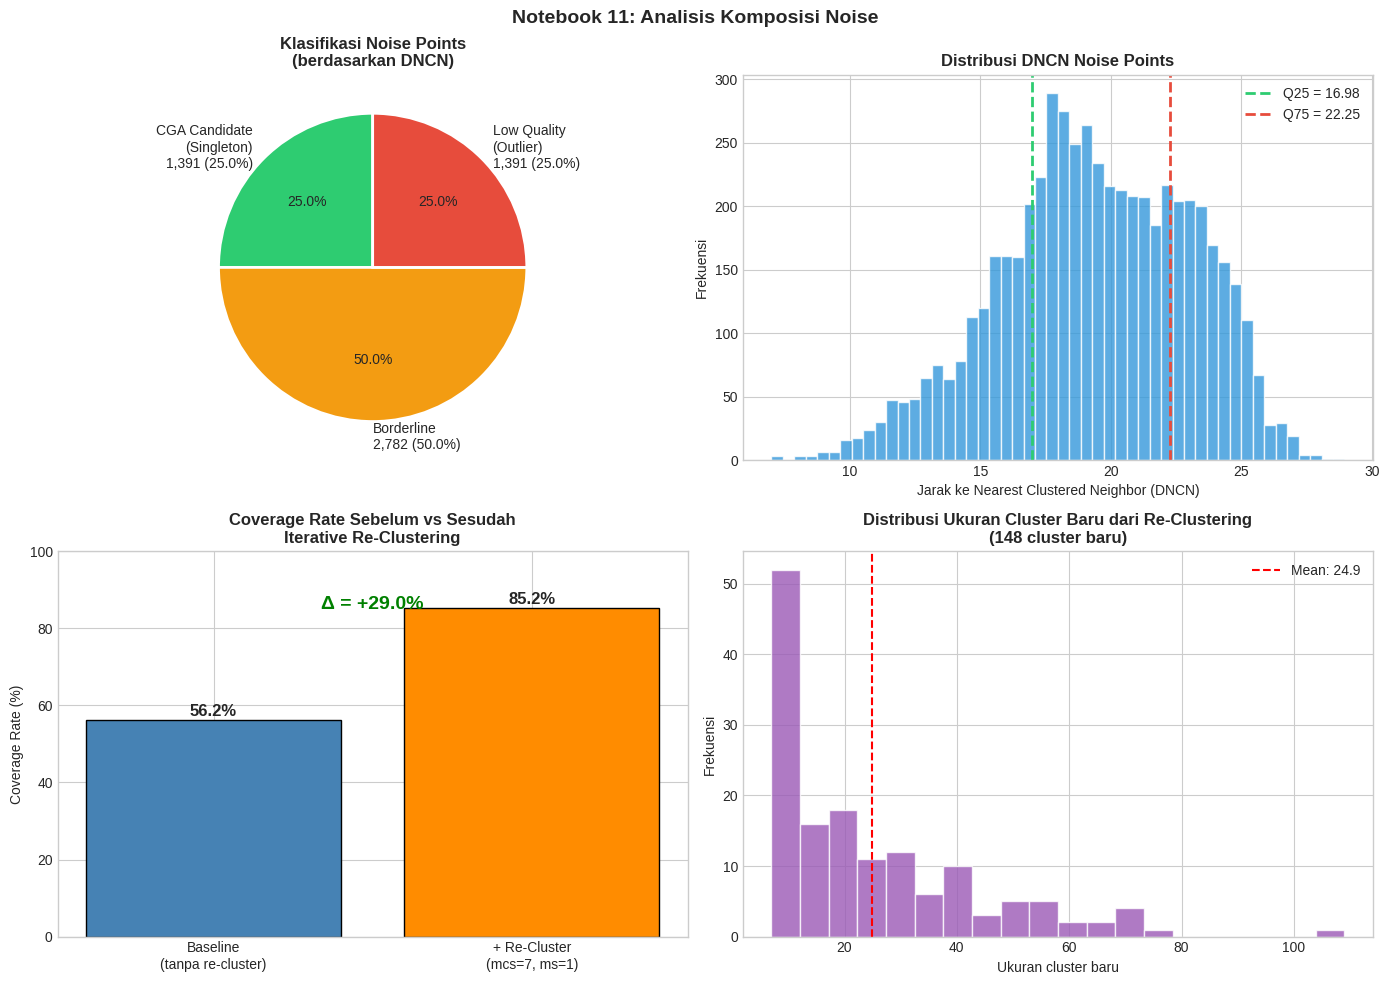

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax_pie, ax_hist, ax_bar, ax_newclust = axes.flatten()

pie_labels = [
    f'CGA Candidate\n(Singleton)\n{n_singleton:,} ({n_singleton/n_noise_base:.1%})',
    f'Borderline\n{n_borderline:,} ({n_borderline/n_noise_base:.1%})',
    f'Low Quality\n(Outlier)\n{n_outlier:,} ({n_outlier/n_noise_base:.1%})',
]
pie_sizes  = [n_singleton, n_borderline, n_outlier]
pie_colors = ['#2ecc71', '#f39c12', '#e74c3c']
ax_pie.pie(pie_sizes, labels=pie_labels, colors=pie_colors,
           autopct='%1.1f%%', startangle=90,
           wedgeprops={'edgecolor': 'white', 'linewidth': 2})
ax_pie.set_title('Klasifikasi Noise Points\n(berdasarkan DNCN)', fontweight='bold')

ax_hist.hist(dncn_all, bins=50, color='#3498db', edgecolor='white', alpha=0.8)
ax_hist.axvline(q25, color='#2ecc71', linestyle='--', linewidth=2, label=f'Q25 = {q25:.2f}')
ax_hist.axvline(q75, color='#e74c3c', linestyle='--', linewidth=2, label=f'Q75 = {q75:.2f}')
ax_hist.set_xlabel('Jarak ke Nearest Clustered Neighbor (DNCN)')
ax_hist.set_ylabel('Frekuensi')
ax_hist.set_title('Distribusi DNCN Noise Points', fontweight='bold')
ax_hist.legend()

bar_labels = ['Baseline\n(tanpa re-cluster)', f'+ Re-Cluster\n(mcs={int(best_refit["mcs"])}, ms={int(best_refit["ms"])})']
cov_vals   = [coverage_base, best_refit['coverage_total']]
bar_colors = ['steelblue', 'darkorange']
bars = ax_bar.bar(bar_labels, [v*100 for v in cov_vals], color=bar_colors, edgecolor='black')
ax_bar.set_ylabel('Coverage Rate (%)')
ax_bar.set_title('Coverage Rate Sebelum vs Sesudah\nIterative Re-Clustering', fontweight='bold')
ax_bar.set_ylim(0, 100)
for bar, val in zip(bars, cov_vals):
    ax_bar.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{val:.1%}', ha='center', fontsize=12, fontweight='bold')
delta_cov = best_refit['coverage_total'] - coverage_base
ax_bar.text(0.5, 0.85, f'Δ = {delta_cov:+.1%}', transform=ax_bar.transAxes,
            ha='center', fontsize=14, fontweight='bold',
            color='green' if delta_cov > 0 else 'red')

best_refit_result = refit_results[df_valid_refit['coverage_total'].argmax()]
best_combined_labels = best_refit_result['labels_combined']
noise_re_labels = best_combined_labels[noise_mask]
new_cluster_labels = noise_re_labels[noise_re_labels != -1]

if len(new_cluster_labels) > 0:
    new_cluster_sizes = Counter(new_cluster_labels)
    sizes = list(new_cluster_sizes.values())
    ax_newclust.hist(sizes, bins=min(20, len(set(sizes))), color='#9b59b6', edgecolor='white', alpha=0.8)
    ax_newclust.set_xlabel('Ukuran cluster baru')
    ax_newclust.set_ylabel('Frekuensi')
    ax_newclust.set_title(f'Distribusi Ukuran Cluster Baru dari Re-Clustering\n({int(best_refit["n_new_clusters"])} cluster baru)', fontweight='bold')
    ax_newclust.axvline(np.mean(sizes), color='red', linestyle='--', label=f'Mean: {np.mean(sizes):.1f}')
    ax_newclust.legend()
else:
    ax_newclust.text(0.5, 0.5, 'Tidak ada cluster baru', ha='center', va='center',
                     transform=ax_newclust.transAxes, fontsize=14)
    ax_newclust.set_title('Distribusi Ukuran Cluster Baru', fontweight='bold')

fig.suptitle('Notebook 11: Analisis Komposisi Noise', fontsize=14, fontweight='bold')
plt.tight_layout()

plot_path = f"{Config.PLOTS_DIR}notebook11_noise_analysis.png"
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"💾 Plot disimpan: {plot_path}")
plt.show()

## Cell 9 — Summary Final & Implikasi untuk CGA

Summary ini menjadi "kesimpulan" analisis pra-CGA yang akan dikutip di skripsi untuk memotivasi pendekatan CGA di Eksperimen 2.

In [ ]:
print("="*70)
print("📋 NOTEBOOK 11 — SUMMARY")
print("="*70)

print(f"""
┌──────────────────────────────────────────────────────────────────────┐
│              ANALISIS KOMPOSISI NOISE — RINGKASAN                    │
├──────────────────────────────────────────────────────────────────────┤
│                                                                      │
│  DATASET:                                                            │
│  • Total embeddings: {len(embeddings):,}                             │
│  • Noise (baseline): {n_noise_base:,} ({1-coverage_base:.1%})        │
│  • Coverage baseline: {coverage_base:.1%}                            │
│                                                                      │
│  KLASIFIKASI NOISE (berdasarkan DNCN):                               │
│  • CGA Candidate (Singleton)  : {n_singleton:,} ({n_singleton/n_noise_base:.1%})  │
│  • Borderline                 : {n_borderline:,} ({n_borderline/n_noise_base:.1%})  │
│  • Low Quality (Outlier)      : {n_outlier:,} ({n_outlier/n_noise_base:.1%})  │
│                                                                      │
│  ITERATIVE RE-CLUSTERING:                                            │
│  • Best config: mcs={int(best_refit['mcs'])}, ms={int(best_refit['ms'])}                              │
│  • Cluster baru dibentuk  : {int(best_refit['n_new_clusters'])}                      │
│  • Noise points recovered : {int(best_refit['n_recovered']):,}                  │
│  • Coverage gain          : +{best_refit['coverage_gain']:.1%}                       │
│  • Total coverage setelah : {best_refit['coverage_total']:.1%}                       │
└──────────────────────────────────────────────────────────────────────┘
""")

# Threshold: singleton >= 30% dari total noise → CGA justified
cga_justified = n_singleton / n_noise_base >= 0.3

print("\n  IMPLIKASI UNTUK CGA:")
if cga_justified:
    print(f"  ✅ CGA JUSTIFIED")
    print(f"  {n_singleton/n_noise_base:.1%} dari noise adalah probable singletons (CGA candidates).")
    print(f"  Ini berarti ada ~{n_singleton:,} wajah yang embedding-nya valid")
    print(f"  tapi tidak memiliki cukup sampel untuk membentuk cluster.")
    print(f"  CGA dapat mensintesis embedding tambahan untuk orang-orang ini.")
else:
    print(f"  ⚠️ CGA KURANG JUSTIFIED")
    print(f"  Hanya {n_singleton/n_noise_base:.1%} noise yang merupakan probable singletons (threshold: ≥30%).")
    print(f"  Mayoritas noise ({n_borderline/n_noise_base:.1%}) berada di kategori borderline —")
    print(f"  tidak cukup dekat maupun jauh dari cluster yang ada untuk diklasifikasikan dengan pasti.")
    print(f"  Outlier kualitas rendah: {n_outlier/n_noise_base:.1%} dari total noise.")
    print(f"  CGA pada data ini mungkin tidak signifikan meningkatkan coverage.")

save_data = {
    'timestamp'            : datetime.now().isoformat(),
    'notebook'             : 'Notebook 11: Noise Composition Analysis',
    'n_total'              : len(embeddings),
    'n_noise_baseline'     : n_noise_base,
    'coverage_baseline'    : coverage_base,
    'dncn_all'             : dncn_all,
    'q25_dncn'             : q25,
    'q75_dncn'             : q75,
    'n_singleton'          : int(n_singleton),
    'n_borderline'         : int(n_borderline),
    'n_outlier'            : int(n_outlier),
    'singleton_mask'       : singleton_mask,
    'outlier_mask'         : outlier_mask,
    'noise_indices'        : noise_indices,
    'refit_results'        : [{k: v for k, v in r.items() if k != 'labels_combined'}
                               for r in refit_results],
    'best_combined_labels' : best_refit_result['labels_combined'],
    'best_refit_params'    : {'mcs': int(best_refit['mcs']), 'ms': int(best_refit['ms'])},
    'best_total_coverage'  : float(best_refit['coverage_total']),
    'cga_justified'        : cga_justified,
}

pkl_path = f"{Config.RESULTS_DIR}notebook11_noise_analysis.pkl"
with open(pkl_path, 'wb') as f:
    pickle.dump(save_data, f)

print(f"\n\n💾 Disimpan: {pkl_path}")
print("\n" + "="*70)
print("🎯 NEXT: Eksperimen 2 — CGA Augmentation")
print("="*70)
print(f"""
   Input untuk CGA:
   • Baseline labels    : {coverage_base:.1%} coverage
   • CGA candidates     : ~{n_singleton:,} noise points
   • Best metric found  : hasil dari Notebook 9 (UMAP) atau 10 (Angular)
   • Combined coverage  : {best_refit['coverage_total']:.1%} (setelah re-clustering)
""")